<a href="https://colab.research.google.com/github/Ignacioelamo/LLMs4Phishing/blob/main/SpamAssassin_Metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and Imports


In [1]:
!pip install spamcheck pandas tqdm scikit-learn matplotlib seaborn -q

In [2]:
import pandas as pd
import spamcheck
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import concurrent.futures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

# Global Seed Initialization

In [3]:
SEED = 56
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Global random seed set to: {SEED}")

Global random seed set to: 56


# Configuration and Data Loading

In [ ]:
NOMBRE_ARCHIVO = 'emails.csv'

!wget -q https://raw.githubusercontent.com/Ignacioelamo/LLMs4Phishing/main/data/01_combined_cleaned_email_data.csv -O $NOMBRE_ARCHIVO

print("--- Data Loading and Preparation ---")
df_original = pd.read_csv(NOMBRE_ARCHIVO)

--- Data Loading and Preparation ---


In [ ]:
train_val_df, test_df = train_test_split(
    df_original,
    test_size=0.1,
    random_state=SEED,
    stratify=df_original['label'] if 'label' in df_original.columns else None
)

print(f"Tamaño del DataFrame original: {len(df_original)}")
print(f"Tamaño del conjunto de test (test_df): {len(test_df)} ({len(test_df)/len(df_original)*100:.2f}%)")
print(f"Tamaño del conjunto de entrenamiento y validación (train_val_df): {len(train_val_df)} ({len(train_val_df)/len(df_original)*100:.2f}%)")

Tamaño del DataFrame original: 10000
Tamaño del conjunto de test (test_df): 1000 (10.00%)
Tamaño del conjunto de entrenamiento y validación (train_val_df): 9000 (90.00%)


Guardamos el test

In [ ]:
test_df.to_csv('test_df.csv', index=False)

In [7]:
ham = pd.read_csv('/content/ham.csv')
phising = pd.read_csv('/content/phishing.csv')

df = pd.concat([ham, phising], ignore_index=True)

# Email Processing and Metrics Calculation Function

In [8]:
def _process_single_email_with_spamcheck(email_row_dict):
    """
    Helper function to process a single email (passed as a dictionary) using spamcheck.
    This function is intended to be used with concurrent.futures.Executor.map.
    """
    subject = email_row_dict.get('subject', '')  # Default to empty string if 'subject' is missing
    body = email_row_dict.get('body', '')    # Default to empty string if 'body' is missing
    email_content = f"Subject: {subject}\n\n{body}"

    try:
        result = spamcheck.check(email_content, report=True)
        score_str = result.get('score', '0.0') # Get score as string, default to '0.0'
        report_content = result.get('report', {"error": "Report not found in spamcheck result"})

        try:
            # Attempt to convert score to float
            score_float = float(score_str)
        except (ValueError, TypeError):
            # If conversion fails, log a warning (optional) and default to 0.0
            # print(f"Warning: spamcheck score '{score_str}' is not numeric. Assuming 0.0.")
            score_float = 0.0

        # Determine predicted label based on score (standard threshold is often 5.0 for SpamAssassin)
        predicted_label = 1 if score_float >= 5.0 else 0
        return predicted_label, score_float, report_content

    except Exception as e:
        # Log the error (optional, can be verbose in parallel processing)
        # print(f"Error processing email with spamcheck: {e}")
        # Return default values in case of an exception during spamcheck call
        return 0, 0.0, {"error": str(e), "details": "Spamcheck API call failed"}


def analyze_emails_and_display_metrics(df_to_analyze, num_threads=10):
    """
    Analyzes emails in the input DataFrame using spamcheck in parallel,
    calculates performance metrics against the 'label' column,
    and displays them with improved visualization including a confusion matrix plot.

    Args:
        df_to_analyze (pd.DataFrame): DataFrame containing 'subject', 'body', and 'label' columns.
        num_threads (int): Number of threads for parallel processing of spamcheck API calls.

    Returns:
        pd.DataFrame: The input DataFrame augmented with 'predicted_label_spamcheck',
                      'spamcheck_score', and 'spamcheck_report' columns.
        dict: A dictionary containing the calculated performance metrics (TP, TN, FP, FN,
              Accuracy, Precision, Recall, F1 Score).
    """
    # Validate required columns
    required_cols = ['subject', 'body', 'label']
    if not all(col in df_to_analyze.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df_to_analyze.columns]
        print(f"Error: DataFrame is missing required columns: {missing_cols}. Cannot proceed.")
        return df_to_analyze, {}

    print(f"\n--- Analyzing DataFrame with {len(df_to_analyze)} emails using spamcheck ---")
    # Work on a copy to avoid modifying the original DataFrame passed to the function
    df_processed = df_to_analyze.copy()

    # Lists to store results from parallel processing
    predicted_labels_list = []
    spamcheck_scores_list = []
    spamcheck_reports_list = [] # Storing full reports can be memory-intensive

    print(f"Processing emails in parallel with {num_threads} threads...")
    # Convert DataFrame rows to a list of dictionaries to pass to the worker function
    email_data_as_dicts = df_processed.to_dict('records')

    # Use ThreadPoolExecutor for I/O-bound tasks like API calls
    all_results_from_map = [] # Initialize list to store all results from the map
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        # map applies the function to each item in the iterable.
        # list() consumes the iterator returned by map and collects all results.
        # tqdm wraps the map iterator to show a progress bar.
        # This structure matches the user's provided example for processing.
        all_results_from_map = list(tqdm(executor.map(_process_single_email_with_spamcheck, email_data_as_dicts),
                                         total=len(email_data_as_dicts),
                                         desc="Analyzing emails"))

    # Iterate through the collected results to populate the individual lists
    for result_tuple in all_results_from_map:
        pred_label, score, report_content = result_tuple # Unpack the tuple
        predicted_labels_list.append(pred_label)
        spamcheck_scores_list.append(score)
        spamcheck_reports_list.append(report_content)

    # Add new columns to the DataFrame
    df_processed['predicted_label_spamcheck'] = predicted_labels_list
    df_processed['spamcheck_score'] = spamcheck_scores_list
    df_processed['spamcheck_report'] = spamcheck_reports_list

    # --- Calculate Performance Metrics ---
    true_labels = df_processed['label'].tolist()
    # predicted_labels_list is already available from the processing step

    print("\n--- Performance Metrics (SpamAssassin Predictions) ---")

    if not true_labels or not predicted_labels_list:
        print("No true labels or predicted labels available to calculate metrics.")
        return df_processed, {}

    # Calculate confusion matrix. Specify labels=[0, 1] to ensure a 2x2 matrix
    # even if one class is not present in predictions or true labels for a small dataset.
    cm = confusion_matrix(true_labels, predicted_labels_list, labels=[0, 1])

    # tn, fp, fn, tp = cm.ravel() sometimes fails if cm is not 2x2.
    # With labels=[0,1], cm will be 2x2.
    # cm[0,0] = TN, cm[0,1] = FP, cm[1,0] = FN, cm[1,1] = TP
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

    # Calculate standard metrics
    # zero_division=0 means if a metric is undefined (e.g., precision when no positive predictions), it returns 0.0.
    accuracy = accuracy_score(true_labels, predicted_labels_list)
    precision = precision_score(true_labels, predicted_labels_list, zero_division=0, labels=[0,1], pos_label=1)
    recall = recall_score(true_labels, predicted_labels_list, zero_division=0, labels=[0,1], pos_label=1)
    f1 = f1_score(true_labels, predicted_labels_list, zero_division=0, labels=[0,1], pos_label=1)

    metrics_summary = {
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Accuracy": accuracy,
        "Precision (Spam)": precision, # Precision for the positive class (spam=1)
        "Recall (Spam)": recall,     # Recall for the positive class (spam=1)
        "F1 Score (Spam)": f1        # F1 Score for the positive class (spam=1)
    }

    # --- Display Metrics with Enhanced Visualization ---
    print("\nConfusion Matrix (Textual):")
    # Create a DataFrame for better textual display of the confusion matrix
    cm_df = pd.DataFrame(
        data=cm,
        columns=['Predicted: Not Spam (0)', 'Predicted: Spam (1)'],
        index=['Actual: Not Spam (0)', 'Actual: Spam (1)']
    )
    print(cm_df)

    print(f"\nBreakdown of Confusion Matrix:")
    print(f"  Verdaderos Positivos (TP) (Spam correctly identified as Spam):       {tp}")
    print(f"  Verdaderos Negativos (TN) (Not Spam correctly identified as Not Spam): {tn}")
    print(f"  Falsos Positivos (FP)   (Not Spam incorrectly flagged as Spam):      {fp}  <-- Type I Error")
    print(f"  Falsos Negativos (FN)   (Spam incorrectly flagged as Not Spam):    {fn}  <-- Type II Error")

    print("\nKey Performance Indicators (KPIs):")
    print(f"  Accuracy:  {metrics_summary['Accuracy']:.4f}  (Overall proportion of correct predictions)")
    print(f"  Precision: {metrics_summary['Precision (Spam)']:.4f}  (Of emails predicted as Spam, proportion that were actually Spam)")
    print(f"  Recall:    {metrics_summary['Recall (Spam)']:.4f}  (Of actual Spam emails, proportion correctly identified)")
    print(f"  F1 Score:  {metrics_summary['F1 Score (Spam)']:.4f}  (Harmonic mean of Precision and Recall, good for imbalanced classes)")

    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Predicted Not Spam (0)', 'Predicted Spam (1)'],
                yticklabels=['Actual Not Spam (0)', 'Actual Spam (1)'])
    plt.title('Confusion Matrix - SpamAssassin Predictions', fontsize=15)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    return df_processed, metrics_summary

# Main


--- Analyzing DataFrame with 400 emails using spamcheck ---
Processing emails in parallel with 32 threads...


Analyzing emails:   0%|          | 0/400 [00:00<?, ?it/s]


--- Performance Metrics (SpamAssassin Predictions) ---

Confusion Matrix (Textual):
                      Predicted: Not Spam (0)  Predicted: Spam (1)
Actual: Not Spam (0)                      200                    0
Actual: Spam (1)                          146                   54

Breakdown of Confusion Matrix:
  Verdaderos Positivos (TP) (Spam correctly identified as Spam):       54
  Verdaderos Negativos (TN) (Not Spam correctly identified as Not Spam): 200
  Falsos Positivos (FP)   (Not Spam incorrectly flagged as Spam):      0  <-- Type I Error
  Falsos Negativos (FN)   (Spam incorrectly flagged as Not Spam):    146  <-- Type II Error

Key Performance Indicators (KPIs):
  Accuracy:  0.6350  (Overall proportion of correct predictions)
  Precision: 1.0000  (Of emails predicted as Spam, proportion that were actually Spam)
  Recall:    0.2700  (Of actual Spam emails, proportion correctly identified)
  F1 Score:  0.4252  (Harmonic mean of Precision and Recall, good for imbalanced c

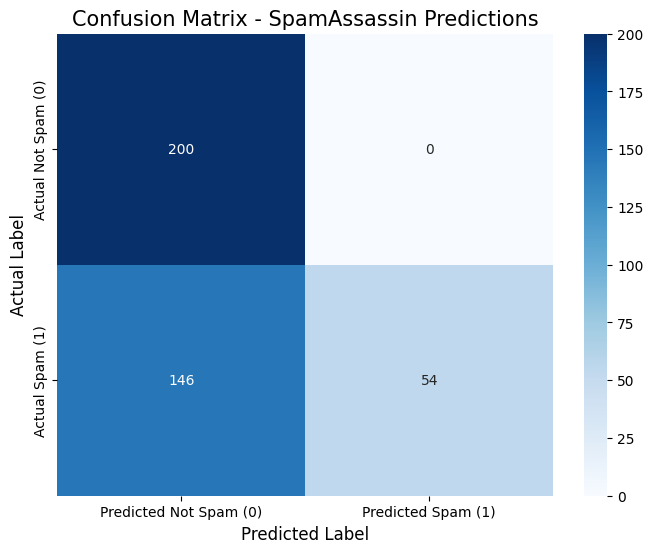


--- Analysis of test_df Complete ---
Showing a sample of the processed DataFrame with new prediction columns:
                                 subject  label  predicted_label_spamcheck  \
0                            adios . . .      0                          0   
1                         summer cookout      0                          0   
2                         ( no subject )      0                          0   
3  how to create copy of a original file      0                          0   
4                         bloomberg fees      0                          0   

   spamcheck_score  
0              3.7  
1              3.4  
2              3.4  
3              3.9  
4              3.7  

Summary of Metrics for the Test Set:
Verdaderos Positivos (TP): 54
Verdaderos Negativos (TN): 200
Falsos Positivos (FP): 0
Falsos Negativos (FN): 146
Accuracy: 0.6350
Precision: 1.0000
Recall: 0.2700
F1 Score: 0.4252


In [9]:
test_df_with_predictions, test_set_metrics = analyze_emails_and_display_metrics(df, num_threads=32)

print("\n--- Analysis of test_df Complete ---")
print("Showing a sample of the processed DataFrame with new prediction columns:")
print(test_df_with_predictions[['subject', 'label', 'predicted_label_spamcheck', 'spamcheck_score']].head())

print("\nSummary of Metrics for the Test Set:")
if test_set_metrics: # Check if metrics were successfully calculated
    print(f"Verdaderos Positivos (TP): {test_set_metrics['TP']}")
    print(f"Verdaderos Negativos (TN): {test_set_metrics['TN']}")
    print(f"Falsos Positivos (FP): {test_set_metrics['FP']}")
    print(f"Falsos Negativos (FN): {test_set_metrics['FN']}")
    print(f"Accuracy: {test_set_metrics['Accuracy']:.4f}")
    # Note: Using the keys as defined in metrics_summary for Precision, Recall, F1
    print(f"Precision: {test_set_metrics['Precision (Spam)']:.4f}")
    print(f"Recall: {test_set_metrics['Recall (Spam)']:.4f}")
    print(f"F1 Score: {test_set_metrics['F1 Score (Spam)']:.4f}")
else:
    print("  No metrics were calculated for the test set.")